In [1]:
import yaml
import pandas as pd
import durationpy
import plotnine as p9
import numpy as np
from plotnine import *
import random
import math
import glob
import os
from pathlib import Path

p9.options.figure_size = (12, 8)
colors = ['#e69f00', '#56b4e9', '#009e73', '#cc79a7', '#000000', '#f0e442', '#0072b2', '#d55e00']

In [2]:
%%time

# keep list in sync with func below and in the desired order for csv out
config_keys = ['workload', 'concurrency', 'profilers']
def config_key(meta):
    profilers = [k for (k, v) in meta['config']['profile'].items() if v == True] or ['none']
    return {
        'workload': meta['config']['workload'],
        'concurrency': meta['config']['concurrency'],
        'profilers': ','.join(profilers),
    }

def list_configs(src_dir):
    configs = {}
    for meta_path in Path(src_dir).rglob('meta.yaml'):
        meta = yaml.load(open(meta_path, 'r'), yaml.CLoader)
        key = frozenset(config_key(meta).items())
        val = {
            'meta': meta,
            'dir': os.path.dirname(meta_path),
        }
        configs[key] = configs.get(key, [])
        configs[key].append(val)
    return configs

configs = list_configs('../long')
len(configs)

CPU times: user 5.15 s, sys: 155 ms, total: 5.31 s
Wall time: 5.63 s


80

In [99]:
%%time
def load_ops(runs, frac = 1):
    """loads the ops.csv files for all runs from the same config and returns them as a combined df"""
    dfs = []
    for idx, run in enumerate(runs):
        df = pd.read_csv(run['dir']+'/ops.csv', parse_dates=['start'], skiprows=lambda i: i>0 and random.random() > frac)
        df['start'] = df['start'] - run['meta']['result']['start']
        df['duration'] = df['duration'].map(pd.to_timedelta)
        df['run'] = idx
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def summary_table(configs):
    frac = 1
    rows = []
    for (key, runs) in configs.items():
        ops = load_ops(runs, frac)
        config = {k: v for (k, v) in key}
        row = {k: config[k] for k in config_keys}
        mean = ops.duration.mean()
        row['mean'] = mean
        row['p99'] = ops.duration.quantile(0.99)
        row['ops'] = len(ops) / frac
        row['min'] = ops.duration.min()
        row['p50'] = ops.duration.quantile(0.5)
        row['max'] = ops.duration.max()
        rows.append(row)

    return pd.DataFrame(rows)

ops = []
for profilers in ['none', 'cpu', 'trace']:
    key = frozenset({'concurrency': 8, 'profilers': profilers, 'workload': 'json'}.items())
    runs = configs[key]
    run_ops = load_ops(runs, 0.01)
    run_ops['profilers'] = profilers
    ops.append(run_ops)

ops = pd.concat(ops, ignore_index=True)
ops

CPU times: user 759 ms, sys: 31.2 ms, total: 790 ms
Wall time: 791 ms


,start,duration,error,run,profilers
0,0 days 00:00:00.363386921,0 days 00:00:00.007932684,NaN,0,none
1,0 days 00:00:02.017857980,0 days 00:00:00.007528,NaN,0,none
2,0 days 00:00:02.481611292,0 days 00:00:00.007408377,NaN,0,none
3,0 days 00:00:03.437269469,0 days 00:00:00.007508262,NaN,0,none
4,0 days 00:00:03.450750092,0 days 00:00:00.007562634,NaN,0,none
...,...,...,...,...,...
14703,0 days 00:00:58.719606121,0 days 00:00:00.004951842,NaN,4,trace
14704,0 days 00:00:58.739205054,0 days 00:00:00.002740859,NaN,4,trace
14705,0 days 00:00:58.945189765,0 days 00:00:00.004955383,NaN,4,trace
14706,0 days 00:00:58.996928727,0 days 00:00:00.002738794,NaN,4,trace


In [100]:
# ops['profilers'] = ops['profilers'].cat.reorder_categories(['pickup', 'suv','minivan','midsize','compact','subcompact','2seater'])
# ops.sort_values(by=['profilers'], key=lambda col: str(['none', 'cpu', 'trace'].index(col)))
ops['profilers'] = pd.Categorical(ops['profilers'], ["none", "cpu", "trace"])

In [96]:
qOps = ops[ops.duration < ops.duration.quantile(.99)]
none_mean = ops[ops['profilers'] == 'none'].duration.mean()

In [101]:
means = ops.groupby(['profilers', 'run']).duration.mean().reset_index()

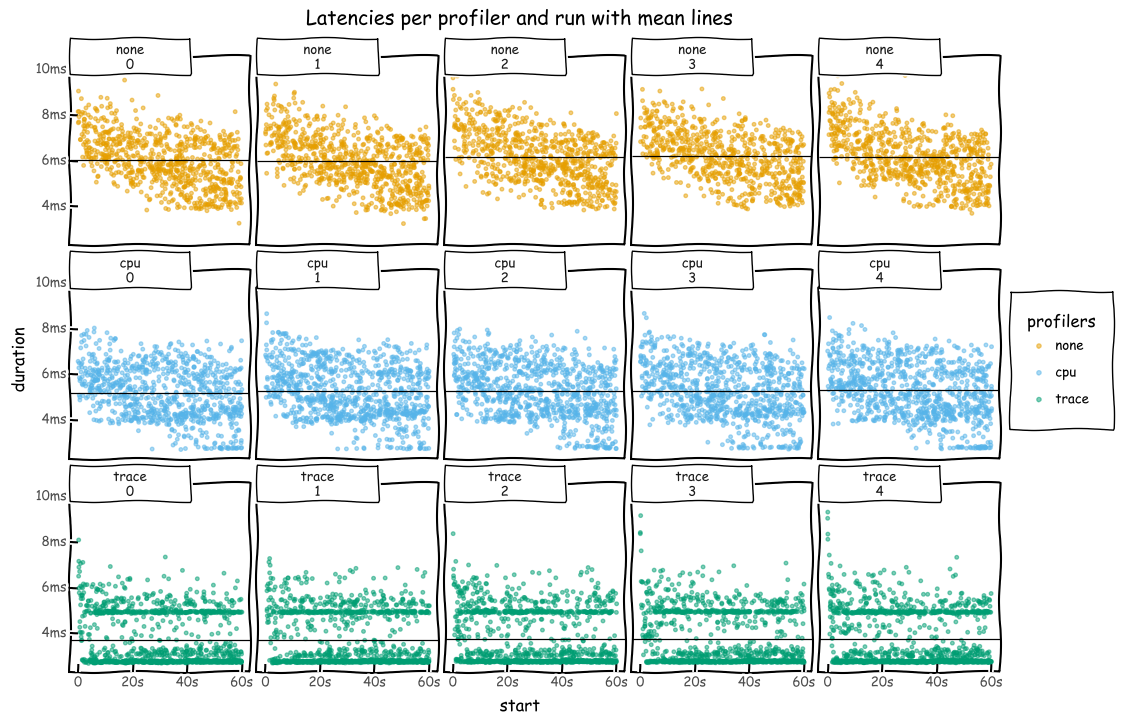

<ggplot: (328851354)>

In [102]:
(
ggplot(ops)
+ aes(x='start',y='duration',color='profilers')
+ geom_point(alpha=0.5, size=1, na_rm=True)
+ facet_wrap(['profilers', 'run'], ncol=5)
+ geom_hline(aes(yintercept = 'duration'), data=means, show_legend=True)
+ ggtitle("Latencies per profiler and run with mean lines")
+ scale_color_manual(values=colors) + theme_xkcd()
)

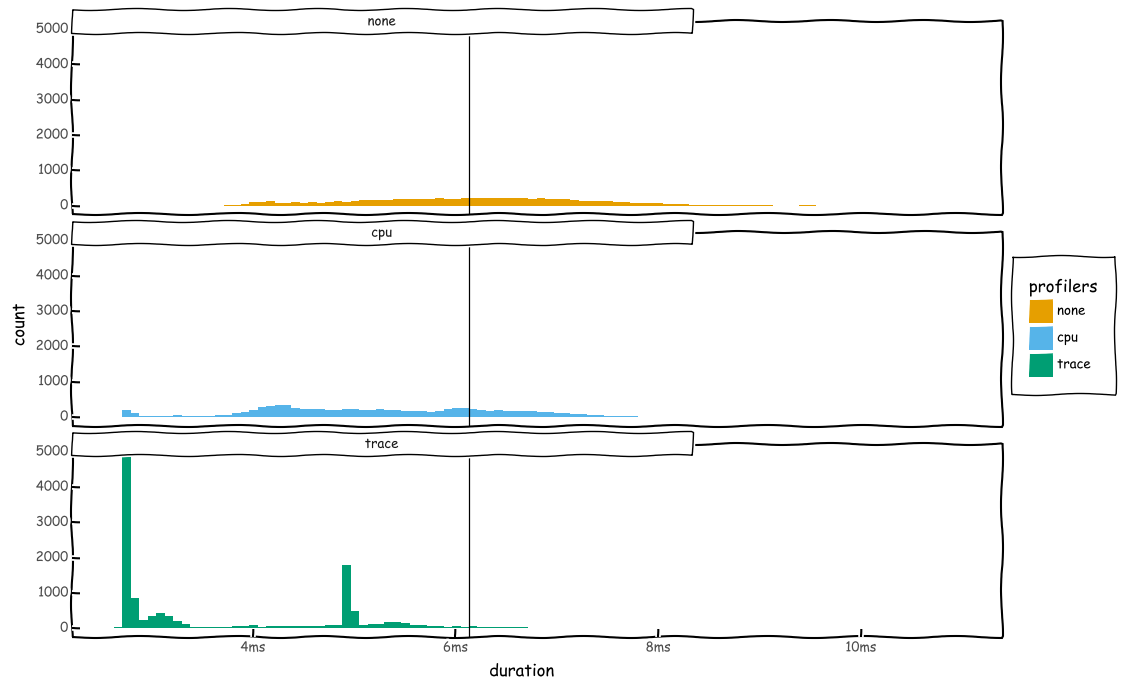

<ggplot: (328636413)>

In [55]:
(
ggplot(ops)
+ aes(x='duration',fill='profilers')
+ geom_histogram(bins=100,position='identity')
+ facet_wrap('profilers',scales='fixed',ncol=1)
+ geom_vline(xintercept = none_mean)
+ scale_fill_manual(values=colors) + theme_xkcd()
)

In [162]:
table.merge()